# Using Pyro with SBI

This how-to-guide shows how to integrate **neural likelihood estimators** (NLE) in Pyro models when analytical likelihoods are intractable. Combining SBI with Pyro enables running inference for posterior in cases of complex, even hierarchical models without hand-deriving likelihoods. For instance, it opens up complex physical simulations with hierarchical structure, cognitive models with individual differences or climate and geospatial models with spatial hierarchies 

In the following, we present the general workflow with a simple Gaussian model :
\begin{align*}
p(\theta)&=\mathcal{N}(\mu,\sigma_0^2I) \\
p(x\mid\theta)&=\mathcal{N}(\theta,\sigma^2I)
\end{align*}
where $\mu$, $\sigma_0$ and $\sigma$ are fixed parameters.
Given an observation $x_0$, the goal is to infer the mean $\theta_0$ in a stochastic manner by sampling from the corresponding posterior distribution $p(\theta\mid x_0)$. For the purpose of this tutorial, we will replace the analytical likelihood with a neural likelihood estimator while retaining Pyro’s modeling structure.  
A more detailed tutorial with hierarchical settings can be found here: https://github.com/janfb/pyro-meets-sbi.

In [1]:
import matplotlib.pyplot as plt
import pyro
import pyro.distributions as dist
import torch
from pyro.infer import MCMC, RandomWalkKernel
from torch.distributions import MultivariateNormal, Normal

# SBI imports
from sbi.inference import NLE
from sbi.utils.pyroutils import to_pyro_distribution

pyro.clear_param_store()

## Neural Likelihood Estimation (NLE) Workflow:
1. **Simulate** $(\theta, x)$ pairs from our model
2. **Train** a neural network that learns $p(x \mid \theta)$ from simulated pairs 
3. **Integrate** the trained estimator in a Pyro's modeling structure
4. **Sample** from the desired posterior $p(\theta \mid x_0)$ using Pyro MCMC.

### Step 1 : Simulate training data

In [2]:
# Generate training data for Neural Likelihood Estimation
torch.manual_seed(42)
num_simulations = 10000
dim = 2

# Sample theta parameters from prior
mu_prior = torch.zeros(dim)
sigma_prior = 1
sigma_model = 1.2
cov_prior = sigma_prior**2*torch.eye(dim)
theta_prior = MultivariateNormal(loc=mu_prior, covariance_matrix=cov_prior)

# Sample parameters from the prior
theta_train = theta_prior.sample((num_simulations,))

# Define a simulator
def gaussian_simulator(theta, sigma):
    return theta + torch.randn_like(theta)*sigma

# Generate observations using the simulator
x_train = gaussian_simulator(theta_train, sigma_model)

print(f"Training dataset: {num_simulations} simulations")

Training dataset: 10000 simulations


### Step 2 : Train a neural likelihood estimator (NLE) on simulations

In [3]:
# Train Neural Likelihood Estimator from simulated data pairs
trainer = NLE(
    prior=theta_prior,
    density_estimator="nsf",
    show_progress_bars=True,
)

nle_net = trainer.append_simulations(
    theta=theta_train,
    x=x_train,
).train()

 Neural network successfully converged after 28 epochs.

### Step 3: Integrate NLE in a Pyro model
Once trained, you can integrate the neural likelihood estimate as a Pyro model using the wrapper function ```to_pyro_distribution()``` that takes as input the conditional density estimator as well as the condition.  
As our model is very simple, we choose to use ```RandomWalkKernel()``` MCMC kernel, but you can replace it by a more performing one (e.g. ```NUTS()```).

In [4]:
#Get a specific observation x_o
theta_o = theta_prior.sample()
x_o = gaussian_simulator(theta_o, sigma_model)

# SBI-Pyro Integration
def sbi_model(x_o=None):
    """Pyro model using SBI neural likelihood"""
    # Same prior as before
    theta = pyro.sample("theta", dist.MultivariateNormal(loc=mu_prior,
                                                         covariance_matrix=cov_prior))

    # Use neural likelihood instead of analytical Gaussian
    with pyro.plate("data"):
        sbi_dist = to_pyro_distribution(nle_net, theta.unsqueeze(0))
        pyro.sample("obs", sbi_dist, obs=x_o)

    return theta


# Run inference with SBI likelihood
pyro.clear_param_store()
kernel = RandomWalkKernel(sbi_model)
mcmc = MCMC(kernel, num_samples=2000, warmup_steps=200, num_chains=1)
mcmc.run(x_o)

sbi_posterior = mcmc.get_samples()

Warmup:   0%|          | 0/2200 [00:00, ?it/s]

Sample: 100%|██████████| 2200/2200 [00:04, 494.61it/s, step size=5.13e-01, acc. prob=0.679]


### Step 4 : Sample from the desired posterior
We use the Pyro MCMC workflow to get samples from the desired posterior. We then compare the obtained marginal densities with analytical ones. Note that our simple example yields a closed-form formula for the posterior 
$p(\theta\mid x_0)=\mathcal{N}(\frac{\sigma_0^2\sigma}{\sigma+\sigma_0}(\frac{\mu}{\sigma_0^2}+\frac{x_0}{\sigma^2}),\frac{\sigma_0^2\sigma}{\sigma+\sigma_0})$.

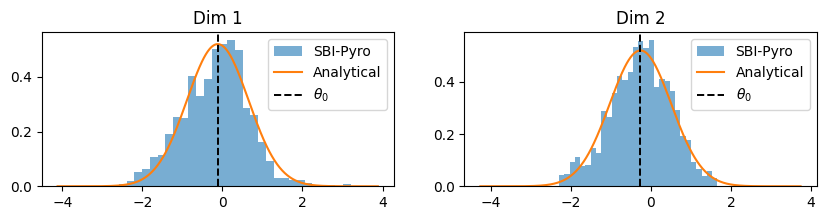

In [5]:
# Define the analytical posterior
sigma_posterior_sq = 1.0/(1.0/sigma_prior**2 + 1.0/sigma_model**2)
mean_posterior = (mu_prior/sigma_prior**2+x_o/sigma_model**2)*sigma_posterior_sq
theta_dim_1 = torch.linspace(mean_posterior[0] - 4, mean_posterior[0] + 4, 500)
theta_dim_2 = torch.linspace(mean_posterior[1] - 4, mean_posterior[1] + 4, 500)
pdf_dim_1 = torch.exp(Normal(mean_posterior[0],sigma_posterior_sq**0.5).log_prob(theta_dim_1))
pdf_dim_2 = torch.exp(Normal(mean_posterior[1],sigma_posterior_sq**0.5).log_prob(theta_dim_2))

fig,ax = plt.subplots(1,2, figsize=(10,2))
ax[0].hist(
        sbi_posterior["theta"][:,0].numpy(),
        bins=30,
        alpha=0.6,
        density=True,
        label="SBI-Pyro",
    )
ax[0].plot(theta_dim_1, pdf_dim_1, label="Analytical")
ax[0].axvline(x=mean_posterior[0], ls="dashed", lw=1.4, color="black", label=r"$\theta_0$")
ax[1].hist(
        sbi_posterior["theta"][:,1].numpy(),
        bins=30,
        alpha=0.6,
        density=True,
        label="SBI-Pyro",
    )
ax[1].plot(theta_dim_2, pdf_dim_2, label="Analytical")
ax[1].axvline(x=mean_posterior[1], ls="dashed", lw=1.4, color="black", label=r"$\theta_0$")

ax[0].set_title("Dim 1")
ax[1].set_title("Dim 2")
ax[0].legend()
ax[1].legend();

## Summary: Same analysis as Pyro — now with SBI

SBI lets you replace an analytical likelihood with a **learned neural likelihood**, while keeping Pyro’s modeling and MCMC workflow **unchanged**.
In particular, this SBI-Pyro compatibility enables hierarchical Bayesian inference for complex models whose analytical likelihood is unavailable or impractical.  
It is also possible to learn a neural posterior estimator (NPE) on simulated data, then integrate it as a prior in a Pyro model using the wrapper function ```to_pyro_distribution()``` introduced previously.